In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Preprocessing
Explicit data인 rating을 implicit으로 변환


In [2]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/dataset/research/user_base.txt', sep = '\t')

Mounted at /content/drive


In [3]:
print(df)

         1   1.1  5  874965758
0        1     2  3  876893171
1        1     3  4  878542960
2        1     4  3  876893119
3        1     5  3  889751712
4        1     7  4  875071561
...    ...   ... ..        ...
79994  943  1067  2  875501756
79995  943  1074  4  888640250
79996  943  1188  3  888640250
79997  943  1228  3  888640275
79998  943  1330  3  888692465

[79999 rows x 4 columns]


In [4]:
df.drop('1.1', axis=1, inplace=True)
df = df.rename(columns = {'1':'user', '874965758':'item', '5':'rating'})

In [5]:
print(df)

       user  rating       item
0         1       3  876893171
1         1       4  878542960
2         1       3  876893119
3         1       3  889751712
4         1       4  875071561
...     ...     ...        ...
79994   943       2  875501756
79995   943       4  888640250
79996   943       3  888640250
79997   943       3  888640275
79998   943       3  888692465

[79999 rows x 3 columns]


In [6]:
# matrix로 변환
df_mat = df.pivot_table(index = 'user', columns = 'item', values = 'rating', fill_value=0)
print(df_mat)

X_hat = tmp_df_mat.to_numpy()
print(X_hat)

item  874724727  874724754  874724781  874724843  874724905  874724937  \
user                                                                     
1             0          0          0          0          0          0   
2             0          0          0          0          0          0   
3             0          0          0          0          0          0   
4             0          0          0          0          0          0   
5             0          0          0          0          0          0   
...         ...        ...        ...        ...        ...        ...   
939           0          0          0          0          0          0   
940           0          0          0          0          0          0   
941           0          0          0          0          0          0   
942           0          0          0          0          0          0   
943           0          0          0          0          0          0   

item  874725264  874728168  874728338

In [7]:
X_hat[X_hat > 0] = 1

# dataset이 이미 20개 이상 user와 item을 기반으로 하고 있어 처리X
non_zero_counts = np.count_nonzero(X_hat, axis=1)
print(non_zero_counts)

[ 96  23  15   9  73  75 131  14   8  43  61  18 179  26  40  41  12  77
   6  24]


### MF에 BPR 적용


In [8]:
class BPR_MF():

  def __init__(self, data, epochs = 200000, learning_rate = 0.01, feat_dim = 30, lambd = 0.01, patience = 10000):
    self.data = data
    self.epochs = epochs
    self.learning_rate = learning_rate
    self.feat_dim = feat_dim
    self.lambd = lambd
    self.patience = patience

  def fit(self):
    # init factorization matrix W, H
    W = np.random.random((self.data.shape[0], self.feat_dim))
    H = np.random.random((self.feat_dim, self.data.shape[1]))

    # init return list, condition
    AUC = []
    num_epochs = []
    last_AUC = 0
    avg_AUC = 0
    sum_AUC =0

    for iter in range(1, self.epochs+1):

      # bootstrap sampling : sample size = 1
      u = np.random.choice(range(self.data.shape[0]))
      if (np.where(self.data[u] == 1)[0] == [] or np.where(self.data[u] == 0)[0] == []):
        continue
      i = np.random.choice(np.where(self.data[u] == 1)[0])
      j = np.random.choice(np.where(self.data[u] == 0)[0])

      ### Update gradient for each triples ###
      # feature vector of each user, item
      w_u = W[u, :]
      h_i = H[:, i]
      h_j = H[:, j]

      # logistic sigmoid part
      x_uij = np.dot(w_u, h_i) - np.dot(w_u, h_j)
      exp = np.exp(-x_uij) / (1 + np.exp(-x_uij))

      # gradient derivatives
      grad_u = exp * (h_i-h_j) + self.lambd * w_u
      grad_i = exp * w_u + self.lambd * h_i
      grad_j = exp * (-w_u) + self.lambd * h_j

      # stochastic gradient descent
      W[u,:] = W[u,:] + self.learning_rate * grad_u
      H[:,i] = H[:,i] + self.learning_rate * grad_i
      H[:,j] = H[:,j] + self.learning_rate * grad_j

      ### AUC calculation for each 100000 epochs ###
      # 평가할때마다 O(|U||I+|I/I+|)만큼씩 소요됨..
      """AUC = 0
      if iter % 1000 == 0:
        for user in range(self.data.shape[0]):
          z_u_inv = len(np.where(self.data[user] == 1)) * len(np.where(self.data[user] == 1))
          sum_delta = 0
          for i in np.where(self.data[user] == 1)[0]:
            for j in np.where(self.data[user] == 0)[0]:
              auc_w_u = W[user, :]
              auc_h_i = H[:, i]
              auc_h_j = H[:, j]
              auc_x_uij = np.dot(w_u, h_i) - np.dot(w_u, h_j)
              if auc_x_uij > 0:
                sum_delta += 1
          AUC += sum_delta / z_u_inv
        avgAUC = AUC / self.data.shape[0]
        print("epoch:", iter, "/ avgAUC:", avgAUC)"""

      # 해당 iteration의 user에서만 AUC 계산
      z_u_inv = len(np.where(self.data[u] == 1)) * len(np.where(self.data[u] == 1))
      if x_uij > 0:
        sum_AUC += 1
      avg_AUC = sum_AUC / iter
      if iter % 100 == 0:
        AUC.append(avg_AUC)
        num_epochs.append(iter)
        print("epoch:",iter,"/ AUC:", avg_AUC)
      if iter % 1000 == 0:
        print("patience:", self.patience)

      # earlystopping
      if (avg_AUC - last_AUC) < 0.0000001:
        self.patience -= 1
      last_AUC = avg_AUC
      if self.patience == 0:
        return AUC, num_epochs

    return AUC, num_epochs


In [9]:
bpr_mf = BPR_MF(X_hat)
auc, epoch = bpr_mf.fit()

epoch: 100 / AUC: 0.48


<ipython-input-8-d4d816b3d941>:27: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if (np.where(self.data[u] == 1)[0] == [] or np.where(self.data[u] == 0)[0] == []):


epoch: 200 / AUC: 0.5
epoch: 300 / AUC: 0.5166666666666667
epoch: 400 / AUC: 0.5375
epoch: 500 / AUC: 0.53
epoch: 600 / AUC: 0.5316666666666666
epoch: 700 / AUC: 0.5328571428571428
epoch: 800 / AUC: 0.53875
epoch: 900 / AUC: 0.5455555555555556
epoch: 1000 / AUC: 0.547
patience: 9547
epoch: 1100 / AUC: 0.5427272727272727
epoch: 1200 / AUC: 0.5408333333333334
epoch: 1300 / AUC: 0.5476923076923077
epoch: 1400 / AUC: 0.5542857142857143
epoch: 1500 / AUC: 0.5513333333333333
epoch: 1600 / AUC: 0.55375
epoch: 1700 / AUC: 0.5541176470588235
epoch: 1800 / AUC: 0.5616666666666666
epoch: 1900 / AUC: 0.5636842105263158
epoch: 2000 / AUC: 0.5585
patience: 9118
epoch: 2100 / AUC: 0.56
epoch: 2200 / AUC: 0.5609090909090909
epoch: 2300 / AUC: 0.561304347826087
epoch: 2400 / AUC: 0.5633333333333334
epoch: 2500 / AUC: 0.5676
epoch: 2600 / AUC: 0.568076923076923
epoch: 2700 / AUC: 0.572962962962963
epoch: 2800 / AUC: 0.5746428571428571
epoch: 2900 / AUC: 0.5734482758620689
epoch: 3000 / AUC: 0.576
patien

<function matplotlib.pyplot.show(close=None, block=None)>

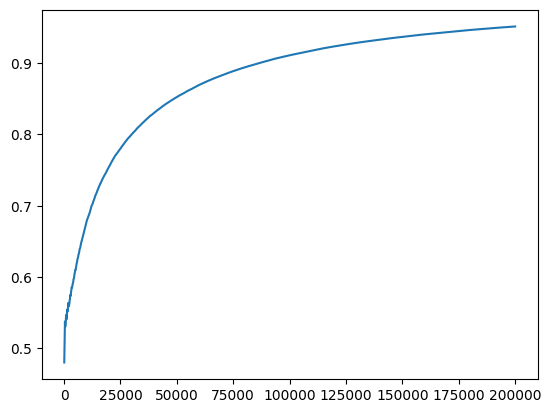

In [10]:
plt.plot(epoch, auc)
plt.show